# Modeling Multiclass IDS (Collapsed 9 Classes) — v4

Fokus:
- DNN reguler (feedforward), ReLU + Dropout (tanpa residual)
- Class weight, AMP, early stopping, gradient clipping
- Transform pipeline locked (fit sekali, reuse)
- Phase A: batch eksplorasi progresif (tanpa adaptive)
- Phase B: final training (default tanpa adaptive; opsi banding adaptive)
- Simpan artefak (state_dict, scaler, cols, heavy_cols, config, report)

In [5]:
# !pip install pandas numpy scikit-learn joblib torch
import pandas as pd
import numpy as np
import json, joblib
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

ART_DIR = Path("./artifacts_multiclass_collapsed_v4")
data_art = joblib.load(ART_DIR / 'lite_clean_data_collapsed.pkl')
full_df = data_art['full_df']
phaseA_df = data_art['phaseA_df']
label_map = data_art['label_map']
inv_label_map = data_art['inv_label_map']
LABEL_COL = data_art['label_col']
feature_cols = data_art['feature_cols']
num_classes = len(label_map)

print("Full data shape:", full_df.shape)
print("Phase A shape:", phaseA_df.shape)
print("Kelas:", num_classes)
print("Fitur final:", len(feature_cols))

Full data shape: (2572527, 83)
Phase A shape: (575741, 83)
Kelas: 9
Fitur final: 58


## 1. Transform Pipeline (fit & apply — locked)

In [6]:
SKEW_THRESHOLD = 1.5
USE_ROBUST_SCALER = True

def transform_fit(X_train_df, X_test_df, skew_threshold=1.5, use_robust=True):
    X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')
    X_test_df  = X_test_df.apply(pd.to_numeric, errors='coerce')
    # Imputasi median berdasar train
    medians = {}
    for c in X_train_df.columns:
        if X_train_df[c].isna().any():
            med = X_train_df[c].median()
            medians[c] = med
            X_train_df[c] = X_train_df[c].fillna(med)
    for c in X_test_df.columns:
        if c in medians:
            X_test_df[c] = X_test_df[c].fillna(medians[c])

    vt = VarianceThreshold(0.0)
    X_train_v = vt.fit_transform(X_train_df)
    cols = [c for c,m in zip(X_train_df.columns, vt.get_support()) if m]
    X_test_v = X_test_df[cols].values

    df_tmp = pd.DataFrame(X_train_v, columns=cols)
    skewness = df_tmp.skew()
    heavy_cols = skewness[abs(skewness) > skew_threshold].index.tolist()
    for c in heavy_cols:
        idx = cols.index(c)
        X_train_v[:, idx] = np.log1p(np.clip(X_train_v[:, idx],0,None))
        X_test_v[:, idx]  = np.log1p(np.clip(X_test_v[:, idx],0,None))

    scaler = RobustScaler() if use_robust else StandardScaler()
    X_train_s = scaler.fit_transform(X_train_v).astype('float32')
    X_test_s  = scaler.transform(X_test_v).astype('float32')
    meta = {'cols': cols, 'heavy_cols': heavy_cols, 'scaler': scaler, 'medians': medians}
    return X_train_s, X_test_s, meta

def transform_apply(X_df, meta):
    cols = meta['cols']; heavy_cols = meta['heavy_cols']; scaler = meta['scaler']; medians = meta['medians']
    X_df = X_df[cols].copy().apply(pd.to_numeric, errors='coerce')
    for c in cols:
        if X_df[c].isna().any():
            fill = medians.get(c, X_df[c].median())
            X_df[c] = X_df[c].fillna(fill)
    for c in heavy_cols:
        if c in X_df.columns:
            X_df[c] = np.log1p(np.clip(X_df[c],0,None))
    X_s = scaler.transform(X_df.values).astype('float32')
    return X_s

## 2. Utilities: class weight, model, training, eval, adaptive (opsional)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)
USE_AMP = torch.cuda.is_available()
scaler = GradScaler(enabled=USE_AMP)

def to_array_features(X):
    if isinstance(X, pd.DataFrame):
        X = X.values
    return np.asarray(X, dtype=np.float32)

def to_array_labels(y):
    if isinstance(y, pd.Series):
        y = y.values
    y = np.asarray(y)
    if y.dtype != np.int64:
        y = y.astype(np.int64)
    return y

def compute_class_weight(y, num_classes):
    counts = Counter(y)
    total = sum(counts.values())
    w = {cls: total / (num_classes * cnt) for cls, cnt in counts.items()}
    return torch.tensor([w.get(i, 1.0) for i in range(num_classes)], dtype=torch.float32)

def adaptive_balance_mild(X, y, benign_id=None, max_benign_ratio=5.0, rare_min=800, random_state=42):
    y = np.asarray(y)
    rng = np.random.default_rng(random_state)
    counts = Counter(y)
    X_new=[]; y_new=[]
    # Benign limiting (opsional jika benign_id diberikan)
    if benign_id is not None and benign_id in counts and len(counts)>1:
        non_benign_max = max(cnt for cls, cnt in counts.items() if cls != benign_id)
        target_benign = int(min(counts[benign_id], max_benign_ratio * non_benign_max))
        idx = np.where(y==benign_id)[0]
        if len(idx) > target_benign:
            idx = rng.choice(idx, size=target_benign, replace=False)
        X_new.append(X[idx]); y_new.append(y[idx])
    # Others
    for cls, cnt in counts.items():
        if benign_id is not None and cls == benign_id:
            continue
        idx = np.where(y==cls)[0]
        if cnt < rare_min:
            extra = rng.choice(idx, size=rare_min - cnt, replace=True)
            idx = np.concatenate([idx, extra])
        X_new.append(X[idx]); y_new.append(y[idx])
    Xb = np.vstack(X_new); yb = np.concatenate(y_new)
    perm = rng.permutation(len(yb))
    return Xb[perm], yb[perm]

def build_dnn(input_dim, layer_sizes, num_classes, activation='relu', dropout=0.35):
    acts = {'relu': nn.ReLU(), 'leaky_relu': nn.LeakyReLU(0.01), 'tanh': nn.Tanh()}
    seq=[]; prev=input_dim
    for h in layer_sizes:
        seq += [nn.Linear(prev, h), acts.get(activation, nn.ReLU()), nn.Dropout(dropout)]
        prev = h
    seq.append(nn.Linear(prev, num_classes))
    return nn.Sequential(*seq)

def train_dnn_amp(model, X_train, y_train, X_val, y_val, class_weight_tensor,
                  lr=0.001, max_epochs=140, batch_size=128, patience=12, accum_steps=1):
    X_train = to_array_features(X_train); y_train = to_array_labels(y_train)
    X_val   = to_array_features(X_val);   y_val   = to_array_labels(y_val)
    ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    model = model.to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor.to(device))
    best_loss=float('inf'); best_state=None; wait=0; step=0
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)
    for epoch in range(max_epochs):
        model.train(); opt.zero_grad()
        for xb,yb in loader:
            xb=xb.to(device); yb=yb.to(device)
            if USE_AMP:
                with autocast():
                    logits = model(xb)
                    loss = criterion(logits, yb)
                scaler.scale(loss).backward()
                nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                step += 1
                if step % accum_steps == 0:
                    scaler.step(opt); scaler.update(); opt.zero_grad()
            else:
                logits = model(xb); loss = criterion(logits, yb)
                loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                step += 1
                if step % accum_steps == 0:
                    opt.step(); opt.zero_grad()
        model.eval()
        with torch.no_grad():
            if USE_AMP:
                with autocast():
                    v_logits = model(X_val_t)
                    v_loss = criterion(v_logits, y_val_t).item()
            else:
                v_logits = model(X_val_t); v_loss = criterion(v_logits, y_val_t).item()
        if v_loss < best_loss - 1e-4:
            best_loss=v_loss; best_state=model.state_dict(); wait=0
        else:
            wait+=1
            if wait>=patience: break
    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def macro_f1_eval(y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return rep['macro avg']['f1-score'], rep

def run_experiment(X_train_df, y_train, X_test_df, y_test,
                   layers, activation, dropout, lr, epochs, batch_size,
                   use_adaptive=False, benign_factor=5.0, accum_steps=1,
                   meta=None, reuse_transform=False):
    # Transform fit or reuse
    if reuse_transform and meta is not None:
        X_train_t = transform_apply(X_train_df[feature_cols], meta)
        X_test_t  = transform_apply(X_test_df[feature_cols], meta)
        cols = meta['cols']; heavy_cols = meta['heavy_cols']; scaler = meta['scaler']
        medians = meta['medians']
    else:
        X_train_t, X_test_t, meta = transform_fit(X_train_df[feature_cols], X_test_df[feature_cols], skew_threshold=SKEW_THRESHOLD, use_robust=USE_ROBUST_SCALER)
        cols = meta['cols']; heavy_cols = meta['heavy_cols']; scaler = meta['scaler']

    # Validation split dari training
    X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
        X_train_t, to_array_labels(y_train), test_size=0.2, stratify=y_train, random_state=RANDOM_STATE)

    # Class weight
    class_w = compute_class_weight(y_tr_sub, num_classes)

    # Adaptive balancing (opsional)
    if use_adaptive:
        # benign id
        benign_id = label_map.get('BENIGN', None)
        X_bal, y_bal = adaptive_balance_mild(X_tr_sub, y_tr_sub, benign_id=benign_id, max_benign_ratio=benign_factor, rare_min=800)
    else:
        X_bal, y_bal = X_tr_sub, y_tr_sub

    # Train
    model = build_dnn(X_bal.shape[1], layers, num_classes, activation=activation, dropout=dropout)
    model = train_dnn_amp(model, X_bal, y_bal, X_val, y_val, class_w,
                          lr=lr, max_epochs=epochs, batch_size=batch_size, patience=12, accum_steps=accum_steps)

    # Evaluate test
    with torch.no_grad():
        logits = model(torch.tensor(X_test_t, dtype=torch.float32).to(device))
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    y_pred = probs.argmax(axis=1)
    mf1, rep = macro_f1_eval(to_array_labels(y_test), y_pred)
    return mf1, rep, model, meta

Device: cuda


/tmp/ipykernel_25484/2075146613.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=USE_AMP)


## 3. Phase A — Batch Eksplorasi Progresif (tanpa adaptive)

In [8]:
phaseA_features = phaseA_df[feature_cols]
phaseA_labels   = phaseA_df['Label_encoded']

# Batch 1: split
split_variants = [0.7, 0.8, 0.9]
baseline_layers = [256,128,128]
baseline_activation = 'relu'
baseline_lr = 0.001
baseline_epochs = 40
baseline_batch_size = 128

batch1=[]
for sr in split_variants:
    X_tr, X_te, y_tr, y_te = train_test_split(phaseA_features, phaseA_labels, train_size=sr, stratify=phaseA_labels, random_state=RANDOM_STATE)
    mf1, rep, model, meta = run_experiment(X_tr, y_tr, X_te, y_te,
        layers=baseline_layers, activation=baseline_activation, dropout=0.35,
        lr=baseline_lr, epochs=baseline_epochs, batch_size=baseline_batch_size,
        use_adaptive=False, benign_factor=5.0, accum_steps=1,
        meta=None, reuse_transform=False)
    batch1.append({'split': sr, 'macro_f1': mf1})
batch1_df = pd.DataFrame(batch1).sort_values('macro_f1', ascending=False)
best_split = float(batch1_df.iloc[0]['split'])
print("Batch1 best split:", best_split)
display(batch1_df)

# Fix split untuk batch berikut
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    phaseA_features, phaseA_labels, train_size=best_split, stratify=phaseA_labels, random_state=RANDOM_STATE)

# Fit transform sekali & reuse
_, _, freeze_meta = transform_fit(X_train_all[feature_cols], X_test_all[feature_cols], skew_threshold=SKEW_THRESHOLD, use_robust=USE_ROBUST_SCALER)

# Batch 2: hidden layers
layer_variants = [[256,128,128],[256,256,128],[256,256,256],[512,256,128]]
batch2=[]
for layers in layer_variants:
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=layers, activation='relu', dropout=0.35, lr=baseline_lr,
        epochs=50, batch_size=baseline_batch_size,
        use_adaptive=False, benign_factor=5.0, accum_steps=1,
        meta=freeze_meta, reuse_transform=True)
    batch2.append({'layers': str(layers), 'macro_f1': mf1})
batch2_df = pd.DataFrame(batch2).sort_values('macro_f1', ascending=False)
top_layers = eval(batch2_df.iloc[0]['layers'])
display(batch2_df)

# Batch 3: activation (tetap simple, relu & leaky_relu)
activation_variants = ['relu','leaky_relu']
batch3=[]
for act in activation_variants:
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=act, dropout=0.35, lr=baseline_lr,
        epochs=50, batch_size=baseline_batch_size,
        use_adaptive=False, benign_factor=5.0, accum_steps=1,
        meta=freeze_meta, reuse_transform=True)
    batch3.append({'activation': act, 'macro_f1': mf1})
batch3_df = pd.DataFrame(batch3).sort_values('macro_f1', ascending=False)
top_activation = batch3_df.iloc[0]['activation']
display(batch3_df)

# Batch 4: epochs (warm/long)
epoch_variants = [60, 100, 140]
batch4=[]
for ep in epoch_variants:
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=top_activation, dropout=0.35, lr=baseline_lr,
        epochs=ep, batch_size=baseline_batch_size,
        use_adaptive=False, benign_factor=5.0, accum_steps=1,
        meta=freeze_meta, reuse_transform=True)
    batch4.append({'epochs': ep, 'macro_f1': mf1})
batch4_df = pd.DataFrame(batch4).sort_values('macro_f1', ascending=False)
top_epochs = int(batch4_df.iloc[0]['epochs'])
display(batch4_df)

# Batch 5: learning rate
lr_variants = [0.001, 0.003]
batch5=[]
for lr in lr_variants:
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=top_activation, dropout=0.35, lr=lr,
        epochs=top_epochs, batch_size=baseline_batch_size,
        use_adaptive=False, benign_factor=5.0, accum_steps=1,
        meta=freeze_meta, reuse_transform=True)
    batch5.append({'lr': lr, 'macro_f1': mf1})
batch5_df = pd.DataFrame(batch5).sort_values('macro_f1', ascending=False)
top_lr = float(batch5_df.iloc[0]['lr'])
display(batch5_df)

# Batch 6: batch size
batch_size_variants = [32, 64, 128]
batch6=[]
for bs in batch_size_variants:
    mf1, rep, model, _ = run_experiment(X_train_all, y_train_all, X_test_all, y_test_all,
        layers=top_layers, activation=top_activation, dropout=0.35, lr=top_lr,
        epochs=top_epochs, batch_size=bs,
        use_adaptive=False, benign_factor=5.0, accum_steps=1 if bs<=128 else 2,
        meta=freeze_meta, reuse_transform=True)
    batch6.append({'batch_size': bs, 'macro_f1': mf1})
batch6_df = pd.DataFrame(batch6).sort_values('macro_f1', ascending=False)
top_bs = int(batch6_df.iloc[0]['batch_size'])
display(batch6_df)

phaseA_final_config = {
    'split': best_split,
    'layers': top_layers,
    'activation': top_activation,
    'epoch': top_epochs,
    'learning_rate': top_lr,
    'batch_size': top_bs,
    'dropout': 0.35
}
print("Phase A Final Config:", phaseA_final_config)

/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is dep

Batch1 best split: 0.7


,split,macro_f1
0,0.7,0.932527
1,0.8,0.912977
2,0.9,0.903535


/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is dep

,layers,macro_f1
0,"[256, 128, 128]",0.937412
2,"[256, 256, 256]",0.925695
1,"[256, 256, 128]",0.911332
3,"[512, 256, 128]",0.909560


/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


,activation,macro_f1
1,leaky_relu,0.912167
0,relu,0.873607


/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is dep

,epochs,macro_f1
1,100,0.935002
2,140,0.912557
0,60,0.906604


/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


,lr,macro_f1
0,0.001,0.933083
1,0.003,0.863628


/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is dep

,batch_size,macro_f1
2,128,0.910410
1,64,0.876701
0,32,0.754583


Phase A Final Config: {'split': 0.7, 'layers': [256, 128, 128], 'activation': 'leaky_relu', 'epoch': 100, 'learning_rate': 0.001, 'batch_size': 128, 'dropout': 0.35}


## 4. Phase B — Final Training (default tanpa adaptive; opsi banding adaptive)

In [9]:
final_split = float(phaseA_final_config['split'])
X_full = full_df[feature_cols]
y_full = full_df['Label_encoded']

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_full, y_full, train_size=final_split, stratify=y_full, random_state=RANDOM_STATE
)

# Lock transform sekali untuk Phase B
_, _, phaseB_meta = transform_fit(X_train_full[feature_cols], X_test_full[feature_cols], skew_threshold=SKEW_THRESHOLD, use_robust=USE_ROBUST_SCALER)

# Config dasar dari Phase A
base_layers = phaseA_final_config['layers']
base_activation = phaseA_final_config['activation']
base_epoch = int(phaseA_final_config['epoch'])
base_lr = float(phaseA_final_config['learning_rate'])
base_batch = int(phaseA_final_config['batch_size'])

# Evaluasi dua opsi: non-adaptive vs adaptive mild (pilih terbaik)
results_phaseB = []
for use_adapt in [False, True]:
    mf1, rep, model, _ = run_experiment(
        X_train_full, y_train_full, X_test_full, y_test_full,
        layers=base_layers, activation=base_activation, dropout=0.35, lr=base_lr,
        epochs=base_epoch, batch_size=base_batch,
        use_adaptive=use_adapt, benign_factor=5.0, accum_steps=1 if base_batch<=128 else 2,
        meta=phaseB_meta, reuse_transform=True)
    results_phaseB.append({'use_adaptive': use_adapt, 'macro_f1': mf1, 'rep': rep, 'model': model})

phaseB_df = pd.DataFrame([{k:v for k,v in r.items() if k!='rep' and k!='model'} for r in results_phaseB]).sort_values('macro_f1', ascending=False)
display(phaseB_df)
best_phaseB_row = phaseB_df.iloc[0].to_dict()
best_use_adapt = bool(best_phaseB_row['use_adaptive'])
best_model_idx = phaseB_df.index[0]
best_model = results_phaseB[best_model_idx]['model']
best_rep = results_phaseB[best_model_idx]['rep']
print("Best Phase B config → use_adaptive:", best_use_adapt, "Macro F1:", best_phaseB_row['macro_f1'])

final_config = {
    'split_ratio': final_split,
    'layers': base_layers,
    'activation': base_activation,
    'learning_rate': base_lr,
    'epochs': base_epoch,
    'batch_size': base_batch,
    'dropout': 0.35,
    'use_adaptive': best_use_adapt,
    'adaptive_params': {'benign_factor': 5.0, 'rare_min': 800}
}
print("Final Config:", final_config)
final_model = best_model
final_rep = best_rep
mf1_final = final_rep['macro avg']['f1-score']
print("Final Macro F1:", mf1_final)

/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipykernel_25484/2075146613.py:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


,use_adaptive,macro_f1
1,True,0.817987
0,False,0.730229


Best Phase B config → use_adaptive: True Macro F1: 0.8179870461637722
Final Config: {'split_ratio': 0.7, 'layers': [256, 128, 128], 'activation': 'leaky_relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 128, 'dropout': 0.35, 'use_adaptive': True, 'adaptive_params': {'benign_factor': 5.0, 'rare_min': 800}}
Final Macro F1: 0.8179870461637722


Accuracy:    0.9970
Macro F1:    0.8180
Weighted F1: 0.9970


,class_id,class_name,precision,recall,f1,support
6,6,Infiltration,0.185185,0.909091,0.307692,11.0
5,5,Heartbleed,0.500000,0.666667,0.571429,3.0
1,1,Bot,0.612111,0.640411,0.625941,584.0
8,8,Web Attack,0.809769,0.979782,0.886700,643.0
4,4,DoS,0.979680,0.999518,0.989500,58124.0
2,2,Brute Force,0.982752,0.996357,0.989508,2745.0
7,7,Port Scan,0.987863,0.999191,0.993495,27208.0
0,0,BENIGN,0.999594,0.996871,0.998231,644037.0
3,3,DDoS,0.999115,0.999661,0.999388,38404.0


/tmp/ipykernel_25484/384410333.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cls.sort_values("f1"), x="f1", y="class_name", palette="viridis")


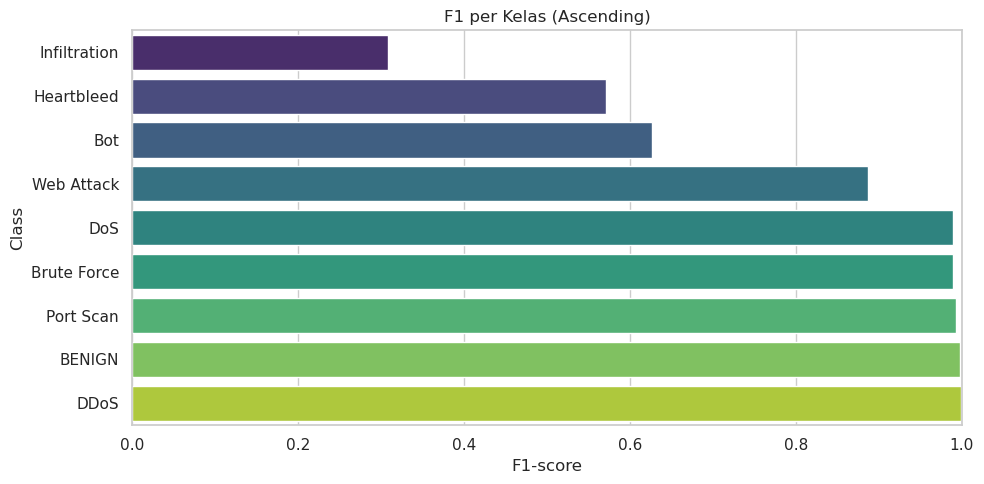

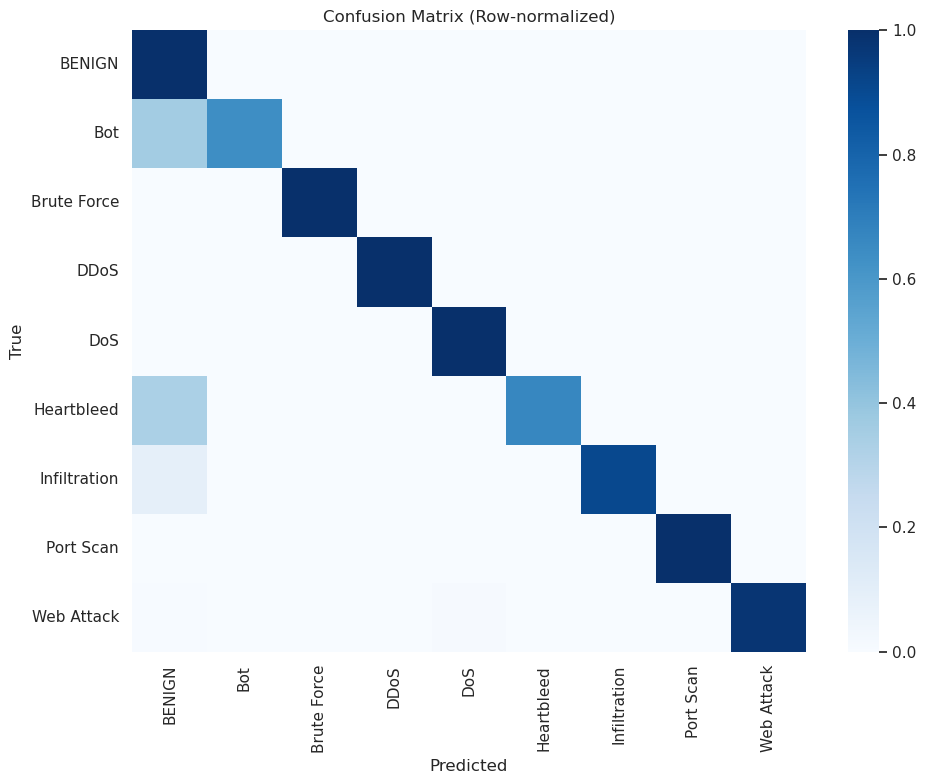

Top-10 Misclassifications (by count):


,true_id,true,pred_id,pred,count,pct_of_true
3,0,BENIGN,4,DoS,1180,0.001832
6,0,BENIGN,7,Port Scan,333,0.000517
0,0,BENIGN,1,Bot,237,0.000368
8,1,Bot,0,BENIGN,210,0.359589
7,0,BENIGN,8,Web Attack,139,0.000216
1,0,BENIGN,2,Brute Force,48,0.000075
5,0,BENIGN,6,Infiltration,44,0.000068
2,0,BENIGN,3,DDoS,32,0.000050
11,4,DoS,0,BENIGN,20,0.000344
18,7,Port Scan,4,DoS,16,0.000588


,true_count,pred_count
BENIGN,644037,642283
Bot,584,611
Brute Force,2745,2783
DDoS,38404,38425
DoS,58124,59301
Heartbleed,3,4
Infiltration,11,54
Port Scan,27208,27520
Web Attack,643,778


/tmp/ipykernel_25484/384410333.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_cls.sort_values("f1"), x="f1", y="class_name", palette="viridis")


Hasil disimpan ke: artifacts_multiclass_collapsed_v4


In [ ]:
# ==== Results & Visualization ====
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

sns.set(style="whitegrid", font_scale=1.0)

def _class_name(idx, inv_label_map):
    try:
        return inv_label_map[int(idx)]
    except Exception:
        return str(idx)

def _report_to_df(rep_dict, inv_label_map):
    rows = []
    for k, v in rep_dict.items():
        if k in ("accuracy", "macro avg", "weighted avg"):
            continue
        # k bisa string dari angka ("0","1",...) atau langsung nama kelas
        try:
            cls_idx = int(k)
            cls_name = inv_label_map.get(cls_idx, str(k))
        except:
            cls_idx = None
            cls_name = k
        rows.append({
            "class_id": cls_idx,
            "class_name": cls_name,
            "precision": v.get("precision", np.nan),
            "recall": v.get("recall", np.nan),
            "f1": v.get("f1-score", np.nan),
            "support": v.get("support", np.nan)
        })
    df = pd.DataFrame(rows)
    if "class_id" in df.columns:
        df = df.sort_values(["f1","class_name"], ascending=[True, True], na_position="last")
    return df

def _transform_apply(df_raw, meta, use_cols):
    # Terapkan transform locked yang sama dengan phaseB
    cols = meta["cols"]; heavy_cols = meta["heavy_cols"]; scaler = meta["scaler"]; medians = meta.get("medians", {})
    X = df_raw[cols].copy().apply(pd.to_numeric, errors="coerce")
    for c in cols:
        if X[c].isna().any():
            X[c] = X[c].fillna(medians.get(c, X[c].median()))
    for c in heavy_cols:
        if c in X.columns:
            X[c] = np.log1p(np.clip(X[c], 0, None))
    return scaler.transform(X.values).astype("float32")

# 1) Siapkan X_test, y_test
X_test_arr = _transform_apply(X_test_full[feature_cols], phaseB_meta, feature_cols)
y_true = y_test_full.to_numpy() if hasattr(y_test_full, "to_numpy") else np.asarray(y_test_full)

# 2) Prediksi
final_model.eval()
with torch.no_grad():
    logits = final_model(torch.tensor(X_test_arr, dtype=torch.float32).to(device))
    probs = torch.softmax(logits, dim=1).cpu().numpy()
y_pred = probs.argmax(axis=1)

# 3) Metrik ringkas
acc = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
weighted_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)
print(f"Accuracy:    {acc:.4f}")
print(f"Macro F1:    {macro_f1:.4f}")
print(f"Weighted F1: {weighted_f1:.4f}")

# 4) Classification report (tabel rapi)
rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
df_cls = _report_to_df(rep, inv_label_map)
display(df_cls)

# 5) Bar chart F1 per kelas (urut dari terendah)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_cls.sort_values("f1"), x="f1", y="class_name", palette="viridis")
plt.title("F1 per Kelas (Ascending)")
plt.xlabel("F1-score")
plt.ylabel("Class")
plt.xlim(0, 1.0)
plt.tight_layout()
plt.show()

# 6) Confusion Matrix (normalisasi baris)
labels_idx = sorted(np.unique(np.concatenate([y_true, y_pred])))
labels_name = [_class_name(i, inv_label_map) for i in labels_idx]
cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
cm_row = cm.astype("float") / (cm.sum(axis=1, keepdims=True) + 1e-9)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_row, annot=False, cmap="Blues", xticklabels=labels_name, yticklabels=labels_name, cbar=True, vmin=0, vmax=1)
plt.title("Confusion Matrix (Row-normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# 7) Top-10 pasangan kelas paling sering salah (off-diagonal)
mis_rows = []
for i, ti in enumerate(labels_idx):
    for j, pj in enumerate(labels_idx):
        if i == j: 
            continue
        cnt = cm[i, j]
        if cnt > 0:
            mis_rows.append({
                "true_id": ti, "true": _class_name(ti, inv_label_map),
                "pred_id": pj, "pred": _class_name(pj, inv_label_map),
                "count": int(cnt),
                "pct_of_true": float(cnt) / (cm[i].sum() + 1e-9)
            })
df_mis = pd.DataFrame(mis_rows).sort_values(["count","pct_of_true"], ascending=[False, False]).head(10)
print("Top-10 Misclassifications (by count):")
display(df_mis)

# 8) Distribusi kelas di test (ground truth vs prediksi)
dist_true = pd.Series(y_true).value_counts().reindex(labels_idx, fill_value=0).rename(index=lambda i: _class_name(i, inv_label_map))
dist_pred = pd.Series(y_pred).value_counts().reindex(labels_idx, fill_value=0).rename(index=lambda i: _class_name(i, inv_label_map))
df_dist = pd.DataFrame({"true_count": dist_true, "pred_count": dist_pred})
display(df_dist)

# 9) Simpan hasil (opsional)
try:
    # Tabel per kelas
    df_cls.to_csv(ART_DIR / "per_class_metrics.csv", index=False)
    # Misclass top10
    df_mis.to_csv(ART_DIR / "top10_misclass.csv", index=False)
    # Distribusi
    df_dist.to_csv(ART_DIR / "test_distribution.csv")
    # Confusion matrix (CSV)
    cm_df = pd.DataFrame(cm, index=labels_name, columns=labels_name)
    cm_df.to_csv(ART_DIR / "confusion_matrix_raw.csv")
    cm_row_df = pd.DataFrame(cm_row, index=labels_name, columns=labels_name)
    cm_row_df.to_csv(ART_DIR / "confusion_matrix_row_normalized.csv")

    # Simpan plot PNG
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df_cls.sort_values("f1"), x="f1", y="class_name", palette="viridis")
    plt.title("F1 per Kelas (Ascending)")
    plt.xlabel("F1-score"); plt.ylabel("Class"); plt.xlim(0,1); plt.tight_layout()
    plt.savefig(ART_DIR / "bar_f1_per_class.png", dpi=150)
    plt.close()

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_row, annot=False, cmap="Blues", xticklabels=labels_name, yticklabels=labels_name, cbar=True, vmin=0, vmax=1)
    plt.title("Confusion Matrix (Row-normalized)")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    plt.savefig(ART_DIR / "confusion_matrix_row_norm.png", dpi=150)
    plt.close()

    with open(ART_DIR / "summary_metrics.txt","w") as f:
        f.write(f"Accuracy: {acc:.6f}\nMacro F1: {macro_f1:.6f}\nWeighted F1: {weighted_f1:.6f}\n")

    print("Hasil disimpan ke:", ART_DIR)
except Exception as e:
    print("Gagal menyimpan hasil ke ART_DIR:", e)

In [13]:
# Evaluasi di TRAIN FULL
X_train_eval = transform_apply(X_train_full[feature_cols], phaseB_meta)
y_train_eval = y_train_full.to_numpy() if hasattr(y_train_full, "to_numpy") else np.asarray(y_train_full)

final_model.eval()
with torch.no_grad():
    train_logits = final_model(torch.tensor(X_train_eval, dtype=torch.float32).to(device))
    train_probs = torch.softmax(train_logits, dim=1).cpu().numpy()
train_pred = train_probs.argmax(axis=1)

# Evaluasi di TEST FULL (kamu sudah punya X_test_arr atau bisa ulang)
X_test_eval = transform_apply(X_test_full[feature_cols], phaseB_meta)
y_test_eval = y_test_full.to_numpy() if hasattr(y_test_full, "to_numpy") else np.asarray(y_test_full)
with torch.no_grad():
    test_logits = final_model(torch.tensor(X_test_eval, dtype=torch.float32).to(device))
    test_probs = torch.softmax(test_logits, dim=1).cpu().numpy()
test_pred = test_probs.argmax(axis=1)

from sklearn.metrics import f1_score, classification_report

train_macro_f1 = f1_score(y_train_eval, train_pred, average='macro', zero_division=0)
test_macro_f1 = f1_score(y_test_eval, test_pred, average='macro', zero_division=0)

print(f"Train Macro F1: {train_macro_f1:.4f}")
print(f"Test  Macro F1: {test_macro_f1:.4f}")
print(f"Generalization gap (Train - Test): {train_macro_f1 - test_macro_f1:.4f}")

# (Opsional) Per-class coba:
rep_train = classification_report(y_train_eval, train_pred, output_dict=True, zero_division=0)
rep_test  = classification_report(y_test_eval, test_pred, output_dict=True, zero_division=0)

def per_class_f1(rep):
    out=[]
    for k,v in rep.items():
        if k in ['accuracy','macro avg','weighted avg']: continue
        try:
            cls_id = int(k)
        except:
            continue
        out.append((cls_id, v['f1-score']))
    return dict(out)

train_f1_per = per_class_f1(rep_train)
test_f1_per  = per_class_f1(rep_test)

print("Per-class F1 gap (train - test):")
for cls_id in sorted(train_f1_per.keys()):
    gap = train_f1_per[cls_id] - test_f1_per.get(cls_id, 0)
    print(f"Class {cls_id}: Train {train_f1_per[cls_id]:.3f} | Test {test_f1_per.get(cls_id,0):.3f} | Gap {gap:.3f}")

Train Macro F1: 0.8258
Test  Macro F1: 0.8180
Generalization gap (Train - Test): 0.0079
Per-class F1 gap (train - test):
Class 0: Train 0.998 | Test 0.998 | Gap 0.000
Class 1: Train 0.600 | Test 0.626 | Gap -0.026
Class 2: Train 0.992 | Test 0.990 | Gap 0.002
Class 3: Train 0.999 | Test 0.999 | Gap 0.000
Class 4: Train 0.990 | Test 0.989 | Gap 0.001
Class 5: Train 0.640 | Test 0.571 | Gap 0.069
Class 6: Train 0.331 | Test 0.308 | Gap 0.023
Class 7: Train 0.994 | Test 0.993 | Gap 0.000
Class 8: Train 0.888 | Test 0.887 | Gap 0.001


## 5. Inference Helper

In [10]:
cols_final = phaseB_meta['cols']
heavy_final = phaseB_meta['heavy_cols']
scaler_final = phaseB_meta['scaler']
medians_final = phaseB_meta['medians']

def predict_label_names(df_raw_subset):
    # Terapkan transform yang sama
    X_arr = transform_apply(df_raw_subset[feature_cols], phaseB_meta)
    with torch.no_grad():
        logits = final_model(torch.tensor(X_arr, dtype=torch.float32).to(device))
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    y_pred = probs.argmax(axis=1)
    labels = [inv_label_map[i] for i in y_pred]
    return labels

# Contoh penggunaan
print(predict_label_names(X_test_full.head(5)))

['BENIGN', 'BENIGN', 'BENIGN', 'BENIGN', 'BENIGN']


## 6. Simpan Artefak Final

In [11]:
torch.save(final_model.state_dict(), ART_DIR / 'final_model_state.pt')
joblib.dump(scaler_final, ART_DIR / 'final_scaler.pkl')
with open(ART_DIR / 'final_transform_meta.json','w') as f:
    json.dump({'cols_final': cols_final, 'heavy_final': heavy_final, 'medians': medians_final}, f, indent=2)
with open(ART_DIR / 'final_config.json', 'w') as f:
    json.dump(final_config, f, indent=2)
with open(ART_DIR / 'final_report.json', 'w') as f:
    json.dump({'macro_f1': mf1_final, 'classification_report': final_rep, 'label_map': label_map}, f, indent=2)
print("Artefak final disimpan ke:", ART_DIR)

Artefak final disimpan ke: artifacts_multiclass_collapsed_v4


In [14]:
from inference_new_dataset import load_artifacts, audit_new_dataset_columns, predict_batch

artifacts = load_artifacts("./artifacts_multiclass_collapsed_v4")
new_df = pd.read_csv("Brute Force.csv")

# Lihat saran mapping
audit_new_dataset_columns(new_df, artifacts)

# Buat manual map jika ada nama beda
manual_map = {
    'Flow Duration': 'flow_duration_ms',   # contoh
    'Total Fwd Packets': 'forward_packets_total',
    # tambahkan sesuai kebutuhan
}

result = predict_batch(new_df, artifacts, manual_map=manual_map, auto_strict=False)
print("Prediksi label pertama:", result['predictions'][:20])

/home/alfanahmuhson/inference_new_dataset.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(state_file, map_location='cpu')


== Saran mapping kolom (harap cek manual jika perlu) ==
               expected_col          expected_canonical                                  suggested_candidates
           Destination Port            destination_port                                            [Dst Port]
              Flow Duration               flow_duration          [Flow Duration, Flow IAT Min, Flow IAT Mean]
          Total Fwd Packets           total_fwd_packets         [Tot Fwd Pkts, TotLen Fwd Pkts, Tot Bwd Pkts]
Total Length of Fwd Packets total_length_of_fwd_packets      [TotLen Fwd Pkts, TotLen Bwd Pkts, Tot Fwd Pkts]
      Fwd Packet Length Max       fwd_packet_length_max  [Fwd Pkt Len Max, Bwd Pkt Len Max, Fwd Pkt Len Mean]
      Fwd Packet Length Min       fwd_packet_length_min  [Fwd Pkt Len Min, Bwd Pkt Len Min, Fwd Pkt Len Mean]
     Fwd Packet Length Mean      fwd_packet_length_mean [Fwd Pkt Len Mean, Bwd Pkt Len Mean, Fwd Pkt Len Min]
      Fwd Packet Length Std       fwd_packet_length_std       [F

KeyError: 'flow_duration_ms'